## Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import prophet

## Data

In [2]:
dataset = pd.read_csv("./listings_det.csv")
dataset.head(3)

id                         listing_url       scrape_id last_scraped  \
0  18674  https://www.airbnb.com/rooms/18674  20240906140800   2024-09-06   
1  23197  https://www.airbnb.com/rooms/23197  20240906140800   2024-09-06   
2  32711  https://www.airbnb.com/rooms/32711  20240906140800   2024-09-06   

        source                                               name  \
0  city scrape    Huge flat for 8 people close to Sagrada Familia   
1  city scrape  Forum CCIB DeLuxe, Spacious, Large Balcony, relax   
2  city scrape                   Sagrada Familia area - Còrsega 1   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful spacious apartment, large terrace, 5...   
2  A lovely two bedroom apartment only 250 m from...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  What's nearby  <br />This apartment is located...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/13031453/413c...    71615  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...    90417  ...   
2  https://a0.muscache.com/pictures/357b25e4-f414...   135703  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.68                   4.78                4.32   
1                        4.99                   4.62                4.64   
2                        4.88                   4.88                4.49   

       license instant_bookable calculated_host_listings_count  \
0  HUTB-002062                t                             28   
1   HUTB005057                f                              1   
2  HUTB-001722                f                              3   

  calculated_host_listings_count_entire_homes  \
0                                          28   
1                                           1   
2                                           3   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.31  
1                                           0              0.48  
2                                           0              0.80  

[3 rows x 75 columns]

In [3]:
dataset.minimum_nights
dataset.host_since

0        2010-01-19
1        2010-03-09
2        2010-05-31
3        2010-01-24
4        2010-01-24
            ...    
19477    2024-03-12
19478    2024-03-12
19479    2024-03-12
19480    2024-05-11
19481    2022-03-01
Name: host_since, Length: 19482, dtype: object

## Transforms & wrangling

In [4]:
df = dataset.copy()

# changing dtypes
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])
df['price'] = df['price'].replace("[$,]", "", regex=True).astype(float)

# creating filters
host_experience_limit = np.datetime64('2023-09-01') # One year as host at least(at September 2024)
reviews_limit = np.datetime64('2024-03-01') # six months limit
minimum_nights_limit = 10

# filterings
df = df[df['host_since'] <= host_experience_limit] #host with one year experience or more only
df = df[df['last_review'] >= reviews_limit] # six months reviewed only

# drop na
reviewed_df = df.dropna(
    subset=['last_review','reviews_per_month', 'price'],
    how='all',
    inplace=False) #delete all rows without reviews per month or a last review data

# filterings
accepted_types = ['Entire home/apt','Private room']
reviewed_df = reviewed_df[reviewed_df['room_type'].isin(accepted_types)] # only accepted types
reviewed_df.head(3)

id                         listing_url       scrape_id last_scraped  \
0  18674  https://www.airbnb.com/rooms/18674  20240906140800   2024-09-06   
1  23197  https://www.airbnb.com/rooms/23197  20240906140800   2024-09-06   
2  32711  https://www.airbnb.com/rooms/32711  20240906140800   2024-09-06   

        source                                               name  \
0  city scrape    Huge flat for 8 people close to Sagrada Familia   
1  city scrape  Forum CCIB DeLuxe, Spacious, Large Balcony, relax   
2  city scrape                   Sagrada Familia area - Còrsega 1   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful spacious apartment, large terrace, 5...   
2  A lovely two bedroom apartment only 250 m from...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  What's nearby  <br />This apartment is located...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/13031453/413c...    71615  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...    90417  ...   
2  https://a0.muscache.com/pictures/357b25e4-f414...   135703  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.68                   4.78                4.32   
1                        4.99                   4.62                4.64   
2                        4.88                   4.88                4.49   

       license instant_bookable calculated_host_listings_count  \
0  HUTB-002062                t                             28   
1   HUTB005057                f                              1   
2  HUTB-001722                f                              3   

  calculated_host_listings_count_entire_homes  \
0                                          28   
1                                           1   
2                                           3   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.31  
1                                           0              0.48  
2                                           0              0.80  

[3 rows x 75 columns]

In [5]:
# grouping
neighbourhood_df = reviewed_df.groupby('neighbourhood_cleansed').agg(
    {
        'price': [('price_mean','mean'), ('listed','count')],
        'review_scores_rating': [('review_scores_rating_mean','mean')]
    }
)
neighbourhood_df

price         \
                                              price_mean listed   
neighbourhood_cleansed                                            
Baró de Viver                                  74.333333      3   
Can Baró                                      191.576923     26   
Canyelles                                     127.000000      2   
Diagonal Mar i el Front Marítim del Poblenou  274.890110     91   
Horta                                          92.857143     14   
...                                                  ...    ...   
la Vila Olímpica del Poblenou                 254.883117     77   
la Vila de Gràcia                             180.913345    577   
les Corts                                     171.263566    129   
les Roquetes                                   93.714286      7   
les Tres Torres                               125.689655     29   

                                                  review_scores_rating  
                                             review_scores_rating_mean  
neighbourhood_cleansed                                                  
Baró de Viver                                                 3.666667  
Can Baró                                                      4.586923  
Canyelles                                                     4.825000  
Diagonal Mar i el Front Marítim del Poblenou                  4.687634  
Horta                                                         4.783333  
...                                                                ...  
la Vila Olímpica del Poblenou                                 4.649877  
la Vila de Gràcia                                             4.600917  
les Corts                                                     4.647021  
les Roquetes                                                  4.445000  
les Tres Torres                                               4.505455  

[69 rows x 3 columns]

In [6]:
# data by neighbourhodd_group
df_listings = pd.read_csv("./listings.csv")
df_listings.groupby("neighbourhood_group")["id"].count().reset_index().sort_values("id")

neighbourhood_group    id
5           Nou Barris   221
6          Sant Andreu   318
4            Les Corts   402
3       Horta-Guinardó   575
9  Sarrià-Sant Gervasi  1061
2               Gràcia  1653
7           Sant Martí  1808
8       Sants-Montjuïc  1997
0         Ciutat Vella  4565
1             Eixample  6882

## Saving & exporting data

In [7]:
neighbourhood_df.to_csv('neighbourhood_df.csv', index = False)

In [8]:
list_filter = ['id',
               'name',
               'host_id',
               'host_since',
               'neighbourhood_cleansed',
               'neighbourhood_group_cleansed',
               'latitude',
               'longitude',
               'room_type',
               'accommodates',
               'price',
               'availability_365',
               'number_of_reviews',
               'first_review',
               'last_review',
               'review_scores_rating',
               'reviews_per_month']
listing_df = df[list_filter]
listing_df.to_csv('listing_df.csv', index = False)

## Forecast for occupations

In [9]:
df_cal = pd.read_csv("calendar.csv")
df_cal.head(3)

/tmp/ipykernel_3339/1970764201.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cal = pd.read_csv("calendar.csv")


listing_id        date available   price adjusted_price  minimum_nights  \
0      331026  2024-09-07         f  $40.00            NaN             3.0   
1      331026  2024-09-08         f  $40.00            NaN             3.0   
2      331026  2024-09-09         f  $40.00            NaN             3.0   

   maximum_nights  
0             6.0  
1             6.0  
2             6.0

In [10]:
df_c = df_cal.copy()
df_c = df_c[df_c["available"]=="f"]
df_ts = df_c.groupby(by=["date"])["listing_id"].count().reset_index().rename(columns={"date":"ds","listing_id":"y"})
df_ts.head(3)

ds      y
0  2024-09-06  13075
1  2024-09-07  17299
2  2024-09-08  15552

04:56:30 - cmdstanpy - INFO - Chain [1] start processing
04:56:30 - cmdstanpy - INFO - Chain [1] done processing


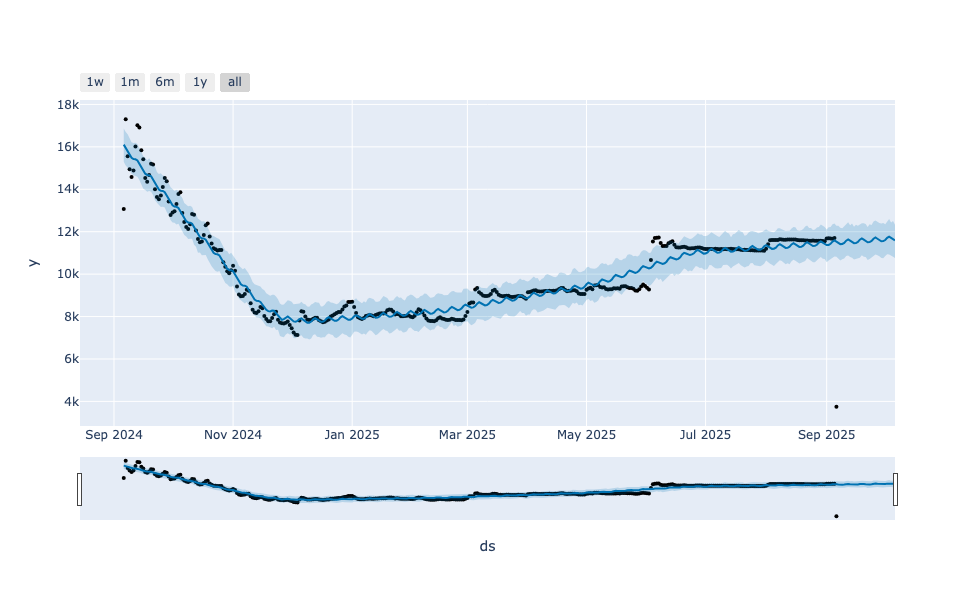

In [11]:
# model
m_prophet = prophet.Prophet()
m_prophet.fit(df_ts)
# forecasted dataframe
df_ts_f = m_prophet.make_future_dataframe(periods=30)
df_4cast = m_prophet.predict(df_ts_f)
# plot
fig = prophet.plot.plot_plotly(m_prophet, df_4cast)
fig.show()

## Animated graph

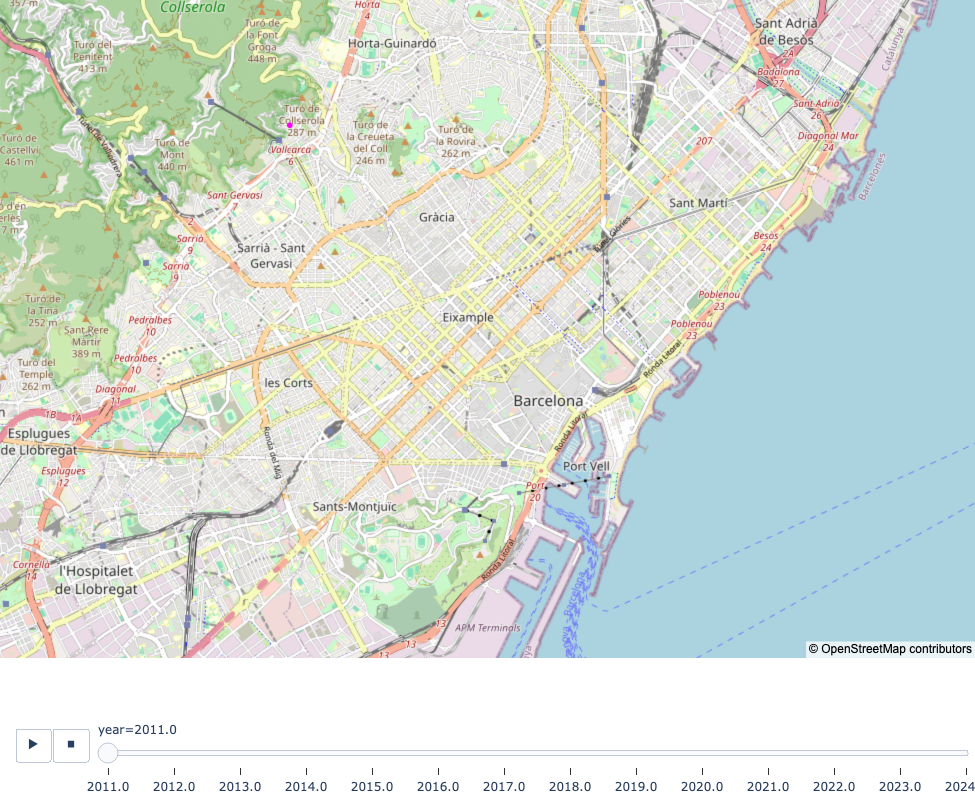

In [13]:
df_y = df_listings.copy()
df_y["last_review"] = pd.to_datetime(df_y["last_review"])
df_y["year"] = df_y["last_review"].dt.year
df_y = df_y.sort_values("year")
fig = px.scatter_map(df_y, lat="latitude", lon="longitude", hover_name="neighbourhood_group",
                        color_discrete_sequence=["fuchsia"], zoom=12, height=800, animation_frame="year")
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Notebook para presentar:

https://deepnote.com/workspace/uady-9d76b52e-3769-4d27-9911-7a4f5b3d9ca1/project/BI-bca9e9d5-08fa-488a-bc8c-06ef3cae9459/notebook/main-c492842e07a347319cb893fe64d488a8

## Archivos:
https://drive.google.com/drive/folders/1nvlTV1ICuR8j3vWnc-wRyZv0fGhdclE4?usp=sharing